In [1]:
#dependencies
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [2]:
resource = pd.read_csv('adc-word.csv')

In [3]:
words = set()
vocab = {}

In [4]:
print(resource.head())

   Unnamed: 0                                          documents  category  \
0           0  አምስት ነባር መንደሮችን ለማፍረስ ከተነሺዎች ጋር ውይይት ሊጀመር ነው ።...         0   
1           1  የኔ ትውልድ ኮንሰርት ዛሬ ይቀርባል ። ከቅርብ ጊዜ ወዲህ ተወዳጅነትን እ...         0   
2           2  ሞሎች እና ብርሀን ። አላማው መብላት ስለሆነ አለማስበላት አላማው ሊሆን ...         0   
3           3  የእርስ በእርስ ግንኙነቶችና ግጭቶች ። የእርስ በእርስ ግንኙነት አንዱ ወ...         0   
4           4  ስምንት መቶ አመታት ያስቆጠሩ የጣና ገዳማት እድሳት እንደሚያስፈልጋቸው ተ...         0   

   labels       source  
0  social     Reporter  
1  social  Addis Admas  
2  social  Addis Admas  
3  social  Addis Admas  
4  social     Reporter  


In [5]:
def clean_and_get_tokens(doc):
    tokens = doc.split()
    table = str.maketrans('','',punctuation)  #removes punctuations using 
    tokens = [w.translate(table) for w in tokens] #dictionary of punctuations
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word)>2]
    return tokens

In [6]:
resource.dropna(subset = ['documents'], inplace=True)
sentences_train, sentences_test, y_train, y_test = train_test_split(resource['documents'], resource['category'], test_size=0.2, random_state=42)

In [7]:
len(sentences_train), len(y_train), len(sentences_test), len(y_test)

(54191, 54191, 13548, 13548)

In [8]:
documents = resource['documents']
for doc in documents:
    tokens = clean_and_get_tokens(doc)
    for token in tokens:
        if token in vocab:
            vocab[token] += 1
        else:
            vocab[token] = 1
for word in vocab:
    if vocab[word] > 5:
        words.add(word)

In [9]:
#train_data,test_data = create_train_test_sets(data,0.8)
train_documents = []
for doc in sentences_train:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    final_string = ' '.join(final_tokens)
    train_documents.append(final_string)

In [10]:
test_documents = []
for doc in sentences_test:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    final_string = ' '.join(final_tokens)
    test_documents.append(final_string)

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_documents)
encoded_docs = tokenizer.texts_to_sequences(train_documents)
max_length = max(([len(s.split()) for s in train_documents]))
labels = y_train#train_data['category']
train_labels = labels
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytrain = keras.utils.to_categorical(labels, num_classes=10)

from scipy import sparse
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
Xtrain, ytrain = sm.fit_sample(sparse.csr_matrix(X_train), y_train.ravel())
labels = y_train#train_data['category']
train_labels = labels
y_train = keras.utils.to_categorical(labels, num_classes=8)

In [12]:
encoded_docs = tokenizer.texts_to_sequences(test_documents)
labels = y_test#test_data['category']
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytest = keras.utils.to_categorical(labels, num_classes=10)

In [13]:
tokenizer.document_count

54191

In [14]:
vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_length))
model.add(Conv1D(filters=16, kernel_size=16, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6211, 100)         17646300  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6196, 16)          25616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3098, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 49568)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                495690    
Total params: 18,167,606
Trainable params: 18,167,606
Non-trainable params: 0
__________________________________________

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=1, verbose=2, validation_data = (Xtest,ytest))

/Users/michaelmelese/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 54191 samples, validate on 13548 samples
Epoch 1/1
 - 1892s - loss: 0.6246 - accuracy: 0.7729 - val_loss: 0.4815 - val_accuracy: 0.8273


In [16]:
random_text = ["I love business and sports"]
encoded_text = tokenizer.texts_to_sequences(random_text)
test_text = pad_sequences(encoded_text, maxlen = max_length, padding= 'post')
model.predict(test_text)

array([[0.10606861, 0.09866916, 0.09595378, 0.1100977 , 0.10384394,
        0.09650005, 0.10717987, 0.09282593, 0.09443508, 0.09442582]],
      dtype=float32)

In [17]:
ypred = model.predict(Xtest)
pred_labels = []
for probs in ypred:
    label = np.argmax(probs, axis=-1)
    pred_labels.append(int(label))
actual_labels = list(labels)

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, pred_labels)

In [22]:
from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(y_test, pred_labels))

Accuracy :  0.8272807794508414


In [19]:
print(cm)

[[4143  337  207   18    4  188   15   14]
 [ 376 2700  112    2    4    0    2   19]
 [ 401  141 2577    0    1    2   20    5]
 [  20    1    0  744    0    0    1    0]
 [  13    2    0    0  614    0    2    0]
 [ 282    3    3    2    1  144    0    0]
 [  67    2   39   12    0    2  191    0]
 [  17    1    0    2    0    0    0   95]]


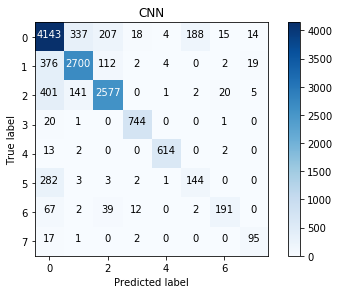

In [20]:
import matplotlib.pyplot as plt
import itertools
cmap = plt.cm.Blues
title = "CNN"
classes = 8
normalize = False
tick_marks = np.arange(classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(10)
#plt.xticks(tick_marks, classes, rotation=45)
#plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 5.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#dependencies

import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.patches as mpatches

#import train data
train = pickle.load(open("train_data","rb"))

train_cat_freq = []

category = list(set(train['category'].tolist()))

for i in category:
    train_cat_freq.append(train['category'].tolist().count(i))

#uncomment this section to view frequency distribution of documents
##plt.bar(category,train_cat_freq)
##plt.show()

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(train.texts).toarray()
print(len(features[1]) == len(features[0]))
labels = train.category

model_tsne = TSNE(n_components=2, verbose = 1, perplexity = 200,
                  learning_rate = 30, random_state=0)

tsne_result = model_tsne.fit_transform(features)
print(tsne_result)
columns = ['X','Y','labels','colors']
df = pd.DataFrame(columns = columns)
df['X'] = tsne_result[:,0]
df['Y'] = tsne_result[:,1]
df['labels'] = labels

colors = ["g","r","y","b",'c']
for i in range(len(df['labels'])):
    df['colors'][i] = colors[df['labels'][i]-1]


gpatch = mpatches.Patch(color='g', label='Business')
rpatch = mpatches.Patch(color='r', label='Entertainment')
ypatch = mpatches.Patch(color='y', label='Politics')
bpatch = mpatches.Patch(color='b', label='Sports')
cpatch = mpatches.Patch(color='c', label='Technology')

plt.legend(handles=[gpatch,rpatch,ypatch,bpatch,cpatch])

cols = [i for i in df['colors']]    
plt.scatter(df['X'],df['Y'],c= cols)
plt.show()